The initial part of the code included only extracting data from the files, and more specifically the relevant ones. Some of these include the info of the races, the results (including the lap times) and the pit stops if we were to use them later on. Moreover we added some data from the results folder, namely the position order. 

In [10]:
import pandas as pd


races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
pitstops = pd.read_csv("pit_stops.csv")
laptimes = pd.read_csv("lap_times.csv")
circuits = pd.read_csv("circuits.csv")
constructors = pd.read_csv("constructors.csv")
constructor_standings = pd.read_csv("constructor_standings.csv")
constructor_results = pd.read_csv("constructor_results.csv")
drivers = pd.read_csv("drivers.csv")
driver_standings = pd.read_csv("driver_standings.csv")
qualifying = pd.read_csv("qualifying.csv")
seasons = pd.read_csv("seasons.csv")
sprint_results = pd.read_csv("sprint_results.csv")
status = pd.read_csv("status.csv")


print("Races:", races.shape)
print("Results:", results.shape)
print("Pitstops:", pitstops.shape)
print("Laptimes:", laptimes.shape)
print("Circuits:", circuits.shape)
print("Constructors:", constructors.shape)
print("Constructor Standings:", constructor_standings.shape)
print("Constructor Results:", constructor_results.shape)
print("Drivers:", drivers.shape)
print("Driver Standings:", driver_standings.shape)
print("Qualifying:", qualifying.shape)
print("Seasons:", seasons.shape)
print("Sprint Results:", sprint_results.shape)
print("Status:", status.shape)

lap_ms = pd.to_numeric(laptimes["milliseconds"], errors="coerce").dropna()


summary = lap_ms.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).rename({
    "count": "n",
    "mean": "mean_ms",
    "std": "sd_ms",
    "min": "min_ms",
    "5%": "q05_ms",
    "25%": "q25_ms",
    "50%": "median_ms",
    "75%": "q75_ms",
    "95%": "q95_ms",
    "max": "max_ms",
})


iqr_ms = summary["q75_ms"] - summary["q25_ms"]
summary = summary.to_frame().T  
summary["iqr_ms"] = iqr_ms


summary_sec = summary.copy()
for col in [c for c in summary.columns if c.endswith("_ms")]:
    summary_sec[col.replace("_ms", "_sec")] = summary[col] / 1000.0

summary = summary.round(1)
summary_sec = summary_sec.round(3)

print("\nLap time distribution (milliseconds):")
print(summary[["n","mean_ms","sd_ms","min_ms","q05_ms","q25_ms","median_ms","q75_ms","q95_ms","max_ms","iqr_ms"]])



Races: (1125, 18)
Results: (26759, 18)
Pitstops: (11371, 7)
Laptimes: (589081, 6)
Circuits: (77, 9)
Constructors: (212, 5)
Constructor Standings: (13391, 7)
Constructor Results: (12625, 5)
Drivers: (861, 9)
Driver Standings: (34863, 7)
Qualifying: (10494, 9)
Seasons: (75, 2)
Sprint Results: (360, 16)
Status: (139, 2)

Lap time distribution (milliseconds):
                     n  mean_ms    sd_ms   min_ms   q05_ms   q25_ms  \
milliseconds  589081.0  95799.4  76399.7  55404.0  74781.0  82041.0   

              median_ms    q75_ms    q95_ms     max_ms   iqr_ms  
milliseconds    90608.0  101930.0  121719.0  7507547.0  19889.0  


Our first goal for the project is to determine the lap times. they were based on some features like the driver, the circuit they’re driving on and the year they’re driving in. To make sure everything runs smoothly, we simply combined them into a relevant matrix which compared all the features in respect to the lap times. 

The primary aim is to predict lap times based on the number of features that include driver-specific and contextual information. for example, the circuit the race is taking place and the year. To complete this task, we joined a few tables from the formula 1 world championships dataset, that include: laps, races, results and drivers into one analytical matrix.

The lap_times table provided the target variable (lap_ms) which is the measured lap time for each driver in milliseconds. The table was filtered to remove missing values and laps that were impossible( <40 s or >180 s) leaving valid race laps only. While the races table provided contextual metadata such as the race year and circuit identifiers, with results providing grid and final positions. Lastly, the final table included the drivers table. It had their names and nationalities that allowed us to connect their performance data directly to the driver behind the wheel.

Once joined, each row in the dataframes represents a single driver on a single lap in a particular race which is suited for a regression model. The selected list of features includes everything known about the driver (name, circuit id, year) and the race features (lap number, grid position and on-track position). all these together capture the effects of the experience, car performance and track conditions simultaneously.

To verify the integrity of the integration we ensured to use the composite key (race id, driver id, lap) which is uniquely identifies the records and prints out some representative rows ro validate data from all the sources which was properly aligned. To validate and use the dataset for modeling we used summary statistics like dataset shape, number of drivers and unique seasons. 

These datasets together were merged and formed the foundation for any additional exploratory analysis and models, where machine models will be trained to discover patterns among these features and resulting lap times.

In [11]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path(".")

laps = pd.read_csv(DATA_DIR / "lap_times.csv")
races = pd.read_csv(DATA_DIR / "races.csv")
results = pd.read_csv(DATA_DIR / "results.csv")
drivers = pd.read_csv(DATA_DIR / "drivers.csv")

laps = laps.rename(columns={"milliseconds": "lap_ms", "position": "lap_position"})
results = results.rename(columns={"positionOrder": "finish_position"})

laps = laps.dropna(subset=["lap_ms"])
laps = laps[(laps.lap_ms >= 40_000) & (laps.lap_ms <= 180_000)]

drivers["driver_name"] = (drivers["forename"].fillna("") + " " + drivers["surname"].fillna("")).str.strip()
drivers_small = drivers[["driverId", "driver_name", "nationality"]]

df = (
    laps
    .merge(races[["raceId", "year", "circuitId"]], on="raceId", how="left")
    .merge(results[["raceId", "driverId", "grid", "finish_position"]], on=["raceId", "driverId"], how="left")
    .merge(drivers_small, on="driverId", how="left")
)

feature_cols = ["driver_name", "lap", "lap_position", "grid", "year", "circuitId"]
X = df[feature_cols].copy()
y = df["lap_ms"].astype(int)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Columns (X):", list(X.columns))
print("Unique drivers:", df["driver_name"].nunique())

print("\nSample rows (with driver_name):")
display(df[feature_cols + ["lap_ms"]].head(20))

print("\nRow key uniqueness (should match total rows):")
print(df[["raceId", "driverId", "lap"]].drop_duplicates().shape, "vs", df.shape)

rid, did = df[["raceId", "driverId"]].drop_duplicates().sample(1, random_state=0).iloc[0]
sample = df[(df.raceId == rid) & (df.driverId == did)].sort_values("lap")
print(f"\nExample sequence for {sample['driver_name'].iloc[0]} in raceId={rid}:")
display(sample[["driver_name","lap","lap_position","lap_ms","grid","finish_position","year","circuitId"]].head(12))


X shape: (587078, 6) | y shape: (587078,)
Columns (X): ['driver_name', 'lap', 'lap_position', 'grid', 'year', 'circuitId']
Unique drivers: 143

Sample rows (with driver_name):


,driver_name,lap,lap_position,grid,year,circuitId,lap_ms
0,Sebastian Vettel,1,1,1,2011,1,98109
1,Sebastian Vettel,2,1,1,2011,1,93006
2,Sebastian Vettel,3,1,1,2011,1,92713
3,Sebastian Vettel,4,1,1,2011,1,92803
4,Sebastian Vettel,5,1,1,2011,1,92342
5,Sebastian Vettel,6,1,1,2011,1,92605
6,Sebastian Vettel,7,1,1,2011,1,92502
7,Sebastian Vettel,8,1,1,2011,1,92537
8,Sebastian Vettel,9,1,1,2011,1,93240
9,Sebastian Vettel,10,1,1,2011,1,92572



Row key uniqueness (should match total rows):
(587078, 3) vs (587078, 12)

Example sequence for Toranosuke Takagi in raceId=195:


,driver_name,lap,lap_position,lap_ms,grid,finish_position,year,circuitId
150006,Toranosuke Takagi,1,15,100521,21,13,1998,4
150007,Toranosuke Takagi,2,15,89798,21,13,1998,4
150008,Toranosuke Takagi,3,15,90256,21,13,1998,4
150009,Toranosuke Takagi,4,15,89144,21,13,1998,4
150010,Toranosuke Takagi,5,15,88927,21,13,1998,4
150011,Toranosuke Takagi,6,15,89105,21,13,1998,4
150012,Toranosuke Takagi,7,15,88885,21,13,1998,4
150013,Toranosuke Takagi,8,15,89106,21,13,1998,4
150014,Toranosuke Takagi,9,15,89162,21,13,1998,4
150015,Toranosuke Takagi,10,15,88780,21,13,1998,4


To undersand properly whether this data can be used to model the lap times, visualization is needed. Some basic plots were drawn and here are some conclusions:

1. From the first plot we see an abundance of laptimes near the 50,000 ms, this can help us determine some possible outliers or even can help us assume a guassian distribution for the data if needed. 
2. The second plot chose a random race to understand how the lap times can be affected by the lap number. This is useful because near the middle we can see a spike in times for all drivers, this can be due to tire degradation which ultimately resulted in pit stops. A further study can be made to determine how corrolated tire degradation is to pit stop (logically it should be high), and see if dimensionality reduction is feasible.
3. The next plot will probably not be used in analysis but more of a preprocessing. A random person might predict that newer models would have drastically different lap times in comparison to older ones, however this graph shows that it is not the case. Indicating that older models will not act as noise and can be used if extra data is ever needed.
4. The final plot indicates how starting position would affect lap times. It is expected for lower starting position would result in lower lap times, which clearly indicates how impactful it is when calculating lap times. 

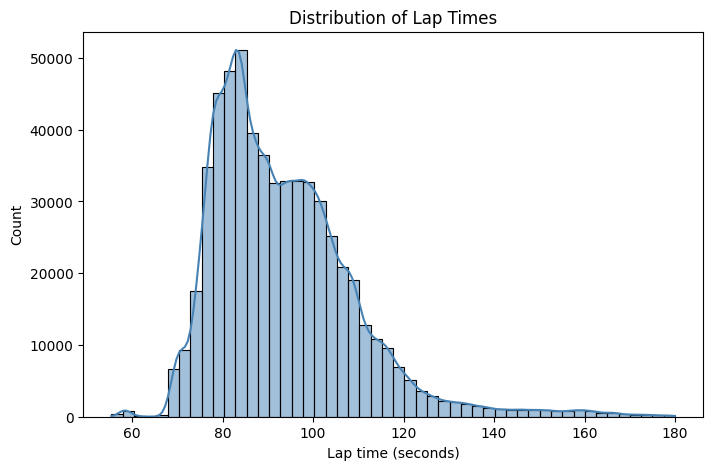

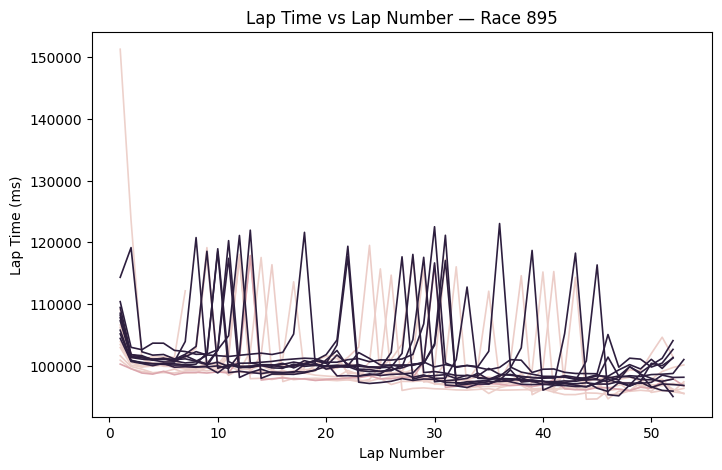

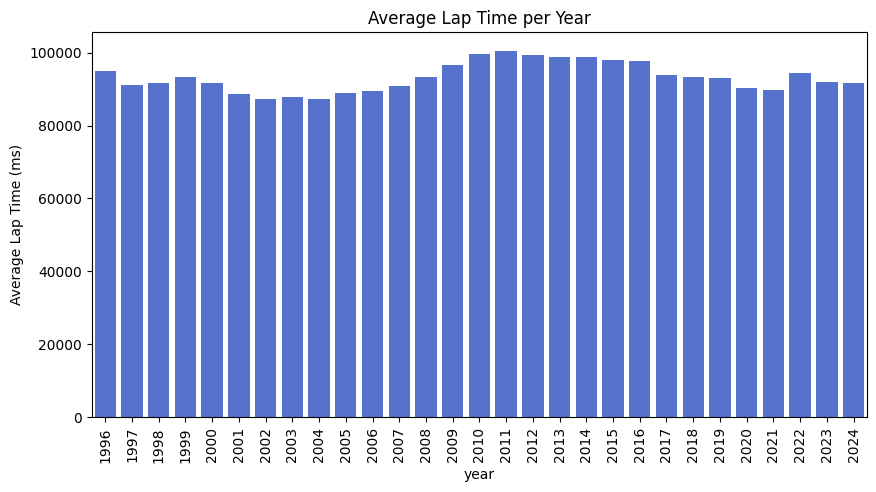

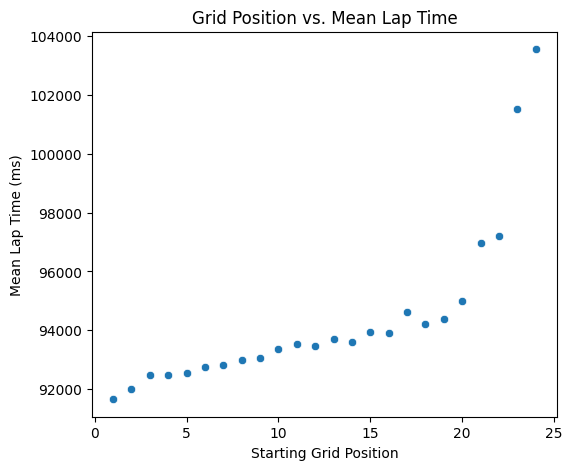

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8,5))
sns.histplot(df["lap_ms"]/1000, bins=50, kde=True, color="steelblue")
plt.xlabel("Lap time (seconds)")
plt.title("Distribution of Lap Times")
plt.show()


race_sample = df["raceId"].sample(1).iloc[0]
subset = df[df["raceId"] == race_sample]

plt.figure(figsize=(8,5))
sns.lineplot(data=subset, x="lap", y="lap_ms", hue="driverId", linewidth=1.2)
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")
plt.title(f"Lap Time vs Lap Number — Race {race_sample}")
plt.legend([],[], frameon=False)
plt.show()


plt.figure(figsize=(10,5))
sns.barplot(data=df.groupby("year", as_index=False)["lap_ms"].mean(),
            x="year", y="lap_ms", color="royalblue")
plt.xticks(rotation=90)
plt.ylabel("Average Lap Time (ms)")
plt.title("Average Lap Time per Year")
plt.show()

df = df[df["grid"] > 0]

grid_perf = df.groupby("grid", as_index=False)["lap_ms"].mean()
plt.figure(figsize=(6,5))
sns.scatterplot(data=grid_perf, x="grid", y="lap_ms")
plt.xlabel("Starting Grid Position")
plt.ylabel("Mean Lap Time (ms)")
plt.title("Grid Position vs. Mean Lap Time")
plt.show()


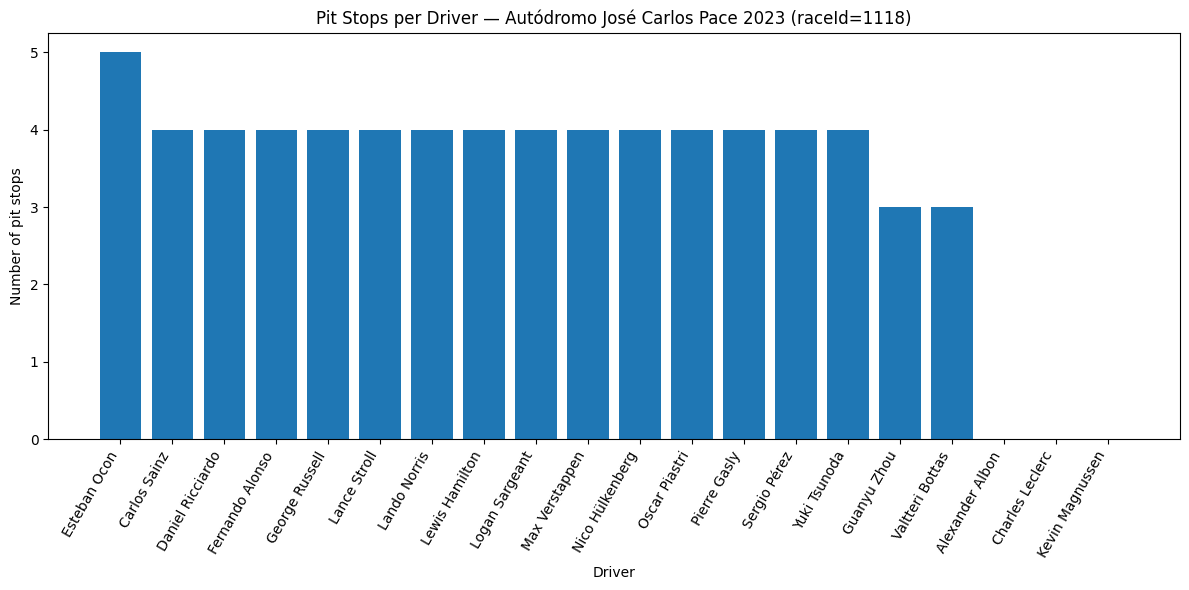

     driver_name  grid  finish_position  num_stops
    Esteban Ocon    14               10          5
    Carlos Sainz     7                6          4
Daniel Ricciardo    17               13          4
 Fernando Alonso     4                3          4
  George Russell     8               15          4
    Lance Stroll     3                5          4
    Lando Norris     6                2          4
  Lewis Hamilton     5                8          4
  Logan Sargeant    19               11          4
  Max Verstappen     1                1          4
 Nico Hülkenberg    11               12          4
   Oscar Piastri    10               14          4
    Pierre Gasly    15                7          4
    Sergio Pérez     9                4          4
    Yuki Tsunoda    16                9          4
     Guanyu Zhou    20               17          3
 Valtteri Bottas    18               16          3
 Alexander Albon    13               19          0
 Charles Leclerc     0         

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
drivers = pd.read_csv("drivers.csv")
circuits = pd.read_csv("circuits.csv")
pitstops = pd.read_csv("pit_stops.csv")


if "finish_position" not in results.columns and "positionOrder" in results.columns:
    results = results.rename(columns={"positionOrder": "finish_position"})


recent_race_ids = races.loc[races["year"] >= 2020, "raceId"]
pit_recent = pitstops[pitstops["raceId"].isin(recent_race_ids)]
if pit_recent.empty:
    raise ValueError("No pit stops found for races in 2020+ in your dataset.")

chosen_race_id = pit_recent["raceId"].drop_duplicates().sample(1, random_state=2).iloc[0]


res_cols_wanted = ["raceId", "driverId", "grid", "finish_position", "positionText", "position"]
res_cols_present = [c for c in res_cols_wanted if c in results.columns]
drivers_in_race = results.loc[results["raceId"] == chosen_race_id, res_cols_present].copy()


if "finish_position" not in drivers_in_race.columns:
    if "position" in drivers_in_race.columns:
        drivers_in_race["finish_position"] = pd.to_numeric(drivers_in_race["position"], errors="coerce")
    elif "positionText" in drivers_in_race.columns:
        drivers_in_race["finish_position"] = pd.to_numeric(drivers_in_race["positionText"], errors="coerce")
    else:
        drivers_in_race["finish_position"] = np.nan

stops = (
    pitstops.loc[pitstops["raceId"] == chosen_race_id]
    .groupby(["raceId", "driverId"], as_index=False)
    .size()
    .rename(columns={"size": "num_stops"})
)


drivers_small = drivers.assign(
    driver_name=(drivers["forename"].fillna("") + " " + drivers["surname"].fillna("")).str.strip()
)[["driverId", "driver_name", "nationality"]]

plot_df = (
    drivers_in_race
    .merge(stops, on=["raceId", "driverId"], how="left")
    .merge(drivers_small, on="driverId", how="left")
)

plot_df["num_stops"] = plot_df["num_stops"].fillna(0).astype(int)


race_meta = races.loc[races["raceId"] == chosen_race_id, ["year", "circuitId"]].iloc[0]
circuit_row = circuits.loc[circuits["circuitId"] == race_meta["circuitId"]]
c_name = (circuit_row["name"].iloc[0] if "name" in circuit_row.columns else f"Circuit {race_meta['circuitId']}")
race_title = f"Pit Stops per Driver — {c_name} {race_meta['year']} (raceId={chosen_race_id})"

plot_df = plot_df.sort_values(["num_stops", "driver_name"], ascending=[False, True])

plt.figure(figsize=(12, 6))
plt.bar(plot_df["driver_name"], plot_df["num_stops"])
plt.title(race_title)
plt.ylabel("Number of pit stops")
plt.xlabel("Driver")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

cols_to_show = [c for c in ["driver_name", "grid", "finish_position", "num_stops"] if c in plot_df.columns]
print(plot_df[cols_to_show].to_string(index=False))
